# Semantic Cell Segmentation using U-Net and Keras

Performing semantic segmentation of cells as a binary classification problem i.e. each pixel in the image is either a part of a cell (white) or not (black).

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
from PIL import Image
from IPython.display import display

# hiding warning messages
import warnings
warnings.filterwarnings('ignore')

In [12]:
# from skimage.io import imread, imshow
# from skimage.transform import resize

## Setting hyperparameters

In [4]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

NUM_TEST_IMAGES = 10

## Exploring data

#### Creating a dataframe

In [5]:
images = os.listdir('/Users/diyatalwar/Desktop/cells/BBBC005_v1_images/BBBC005_v1_images')
masks = os.listdir('/Users/diyatalwar/Desktop/cells/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth')

df_images = pd.DataFrame(images, columns=['image_id'])

# filtering out '.htaccess'
df_images = df_images[df_images['image_id'] != '.htaccess']

In [6]:
# adding a column for number of cells in each image
def get_num_cells(x):
    a = x.split('_')
    b = a[2] # choosing third item in the list of image name components
    num_cells = int(b[1:]) # ignoring letter in the ID
    
    return num_cells

df_images['num_cells'] = df_images['image_id'].apply(get_num_cells)

In [7]:
# adding a column indicating if image has a corresponding mask in the given dataset
def check_mask(x):
    if x in masks:
        return 'yes'
    else:
        return 'no'
    
df_images['has_mask'] = df_images['image_id'].apply(check_mask)

In [8]:
# adding a column indicating amount of blur applied to image
def get_blur_amt(x):
    a = x.split('_')
    b = a[3] # choosing fourth item from list of name components
    blur_amt = int(b[1:])
    
    return blur_amt

df_images['blur_amt'] = df_images['image_id'].apply(get_blur_amt)

#### Displaying dataframe

In [9]:
df_images.head(10)

,image_id,num_cells,has_mask,blur_amt
0,SIMCEPImages_D07_C27_F10_s03_w2.TIF,27,no,10
1,SIMCEPImages_I24_C100_F26_s04_w2.TIF,100,no,26
2,SIMCEPImages_O18_C74_F45_s13_w1.TIF,74,no,45
3,SIMCEPImages_J11_C44_F29_s20_w1.TIF,44,no,29
4,SIMCEPImages_M11_C44_F39_s08_w2.TIF,44,no,39
5,SIMCEPImages_E20_C83_F14_s22_w2.TIF,83,no,14
6,SIMCEPImages_A13_C53_F1_s09_w2.TIF,53,yes,1
7,SIMCEPImages_A03_C10_F1_s20_w1.TIF,10,yes,1
8,SIMCEPImages_K10_C40_F32_s09_w1.TIF,40,no,32
9,SIMCEPImages_B09_C35_F4_s06_w2.TIF,35,no,4


#### Creating dataframe for images with masks

In [10]:
df_masks = df_images[df_images['has_mask'] == 'yes']

df_masks['mask_id'] = df_images['image_id']

df_masks.shape

(1200, 5)

In [11]:
df_masks.head(10)

,image_id,num_cells,has_mask,blur_amt,mask_id
6,SIMCEPImages_A13_C53_F1_s09_w2.TIF,53,yes,1,SIMCEPImages_A13_C53_F1_s09_w2.TIF
7,SIMCEPImages_A03_C10_F1_s20_w1.TIF,10,yes,1,SIMCEPImages_A03_C10_F1_s20_w1.TIF
22,SIMCEPImages_A01_C1_F1_s07_w2.TIF,1,yes,1,SIMCEPImages_A01_C1_F1_s07_w2.TIF
34,SIMCEPImages_A16_C66_F1_s06_w1.TIF,66,yes,1,SIMCEPImages_A16_C66_F1_s06_w1.TIF
45,SIMCEPImages_A20_C83_F1_s07_w2.TIF,83,yes,1,SIMCEPImages_A20_C83_F1_s07_w2.TIF
54,SIMCEPImages_A06_C23_F1_s24_w1.TIF,23,yes,1,SIMCEPImages_A06_C23_F1_s24_w1.TIF
76,SIMCEPImages_A02_C5_F1_s24_w1.TIF,5,yes,1,SIMCEPImages_A02_C5_F1_s24_w1.TIF
104,SIMCEPImages_A24_C100_F1_s16_w1.TIF,100,yes,1,SIMCEPImages_A24_C100_F1_s16_w1.TIF
110,SIMCEPImages_A14_C57_F1_s11_w2.TIF,57,yes,1,SIMCEPImages_A14_C57_F1_s11_w2.TIF
112,SIMCEPImages_A07_C27_F1_s10_w2.TIF,27,yes,1,SIMCEPImages_A07_C27_F1_s10_w2.TIF


## Creating a test set

Creating a test set with 10 images.

In [12]:
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state = 101)

df_test = df_test.reset_index(drop=True) # resetting index

test_image_list = list(df_test['image_id'])

# filter out images to be used for testing:
df_masks = df_masks[~df_masks['image_id'].isin(test_image_list)]

In [13]:
df_masks.shape

(1190, 5)

In [14]:
df_test.shape

(10, 5)

## Checking sample image and mask

In [15]:
# checking sample image and mask

filename = 'SIMCEPImages_A09_C35_F1_s20_w2.TIF'
img_path = os.path.join('/Users/diyatalwar/Desktop/cells/BBBC005_v1_images/BBBC005_v1_images', filename)
mask_path = os.path.join('/Users/diyatalwar/Desktop/cells/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth', filename)


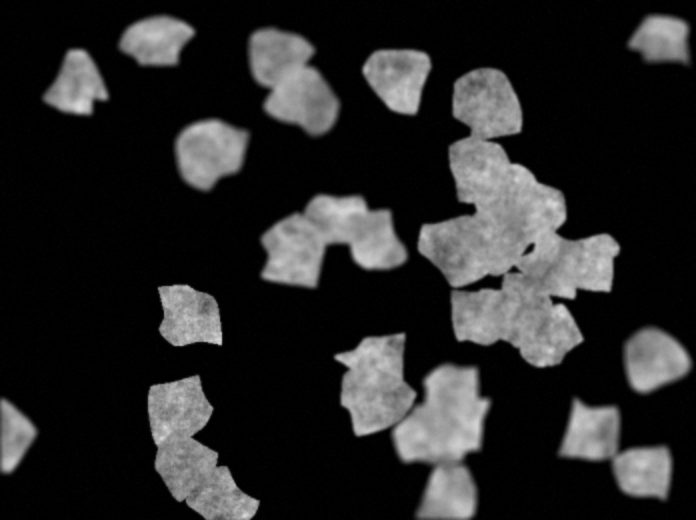

In [16]:
image = Image.open(img_path)
display(image)

In [17]:
img = cv.imread(img_path)
print('Shape: ', img.shape)
print('Max pixel value: ', img.max())
print('Min pixel value: ', img.min())

Shape:  (520, 696, 3)
Max pixel value:  218
Min pixel value:  0


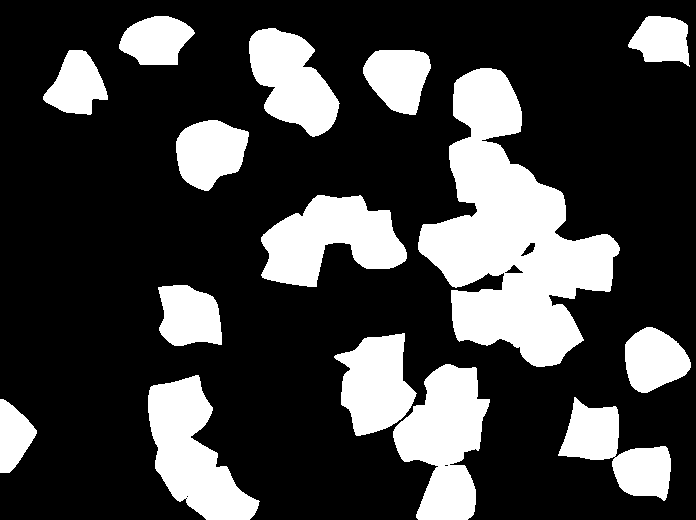

In [18]:
mask = Image.open(mask_path)
display(mask)

In [19]:
msk = cv.imread(mask_path)
print('Shape: ', msk.shape)
print('Max pixel value: ', msk.max())
print('Min pixel value: ', msk.min())

Shape:  (520, 696, 3)
Max pixel value:  255
Min pixel value:  0


## Creating X_train, Y_train, and X_test

In [20]:
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

#### X_train

In [21]:
for i, image_id in enumerate(image_id_list):
    path = os.path.join('/Users/diyatalwar/Desktop/cells/BBBC005_v1_images/BBBC005_v1_images', image_id)
    image = cv.imread(path)
    # resizing to 128 x 128
    image = cv.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv.INTER_AREA)
    # changing depth of image from 3 (RGB) to 1 (Grayscale)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=-1)
    X_train[i] = image

X_train.shape

(1190, 128, 128, 1)

#### Y_train

In [22]:
for i, mask_id in enumerate(mask_id_list):
    path = os.path.join('/Users/diyatalwar/Desktop/cells/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth', mask_id)
    mask = cv.imread(path)
    # resizing to 128 x 128
    mask = cv.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
    # changing depth of image from 3 (RGB) to 1 (Grayscale)
    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    Y_train[i] = mask
    
Y_train.shape    

(1190, 128, 128, 1)

#### X_test

In [23]:
for i, image_id in enumerate(test_id_list):
    path = os.path.join('/Users/diyatalwar/Desktop/cells/BBBC005_v1_images/BBBC005_v1_images', image_id)
    image = cv.imread(path)
    # resizing to 128 x 128
    image = cv.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
    # changing depth of image from 3 (RGB) to 1 (Grayscale)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=-1)
    X_test[i] = image
    
X_test.shape

(10, 128, 128, 1)

## Defining model architecture

The images are normalized inside the model using a lamda layer.

In [24]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

2023-10-09 01:56:00.081404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()


2023-10-09 01:56:10.720248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

 conv2d_15 (Conv2D)             (None, 64, 64, 32)   9248        ['dropout_7[0][0]']              
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
          

## Training the model

In [42]:
filepath = 'model.h5'

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=callbacks_list)

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.0938
Epoch 1: val_loss improved from inf to 0.03076, saving model to model.h5
67/67 [==============================] - 57s 799ms/step - loss: 0.0938 - val_loss: 0.0308
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.0305
Epoch 2: val_loss improved from 0.03076 to 0.02378, saving model to model.h5
67/67 [==============================] - 55s 813ms/step - loss: 0.0305 - val_loss: 0.0238
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.0256
Epoch 3: val_loss improved from 0.02378 to 0.02095, saving model to model.h5
67/67 [==============================] - 59s 884ms/step - loss: 0.0256 - val_loss: 0.0209
Epoch 4/50
67/67 [==============================] - ETA: 0s - loss: 0.0233
Epoch 4: val_loss improved from 0.02095 to 0.01944, saving model to model.h5
67/67 [==============================] - 57s 845ms/step - loss: 0.0233 - val_loss: 0.0194
Epoch 5/50
67/67 [==================

Epoch 36/50
67/67 [==============================] - ETA: 0s - loss: 0.0107
Epoch 36: val_loss did not improve from 0.00920
67/67 [==============================] - 59s 877ms/step - loss: 0.0107 - val_loss: 0.0100
Epoch 37/50
67/67 [==============================] - ETA: 0s - loss: 0.0105
Epoch 37: val_loss did not improve from 0.00920
67/67 [==============================] - 58s 873ms/step - loss: 0.0105 - val_loss: 0.0092
Epoch 38/50
67/67 [==============================] - ETA: 0s - loss: 0.0103
Epoch 38: val_loss improved from 0.00920 to 0.00903, saving model to model.h5
67/67 [==============================] - 58s 871ms/step - loss: 0.0103 - val_loss: 0.0090
Epoch 39/50
67/67 [==============================] - ETA: 0s - loss: 0.0103
Epoch 39: val_loss did not improve from 0.00903
67/67 [==============================] - 59s 874ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 40/50
67/67 [==============================] - ETA: 0s - loss: 0.0100
Epoch 40: val_loss did not improve fro

## Making a prediction

In [26]:
# loading the best epoch
model.load_weights('model.h5')

test_preds = model.predict(X_test)

1/1 [==============================] - 0s 349ms/step


In [27]:
# thresholding the predictions
preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)

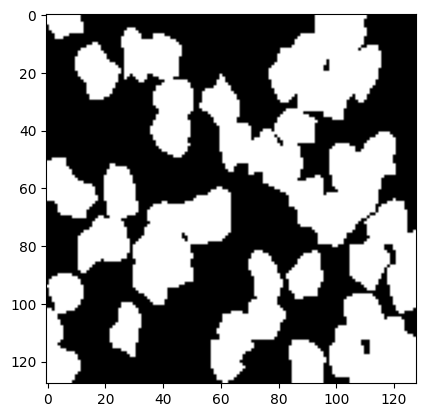

In [28]:
# displaying a thresholded mask
test_img = preds_test_thresh[5, :, :, 0]

plt.imshow(test_img, cmap='gray')

## Inspecting the results

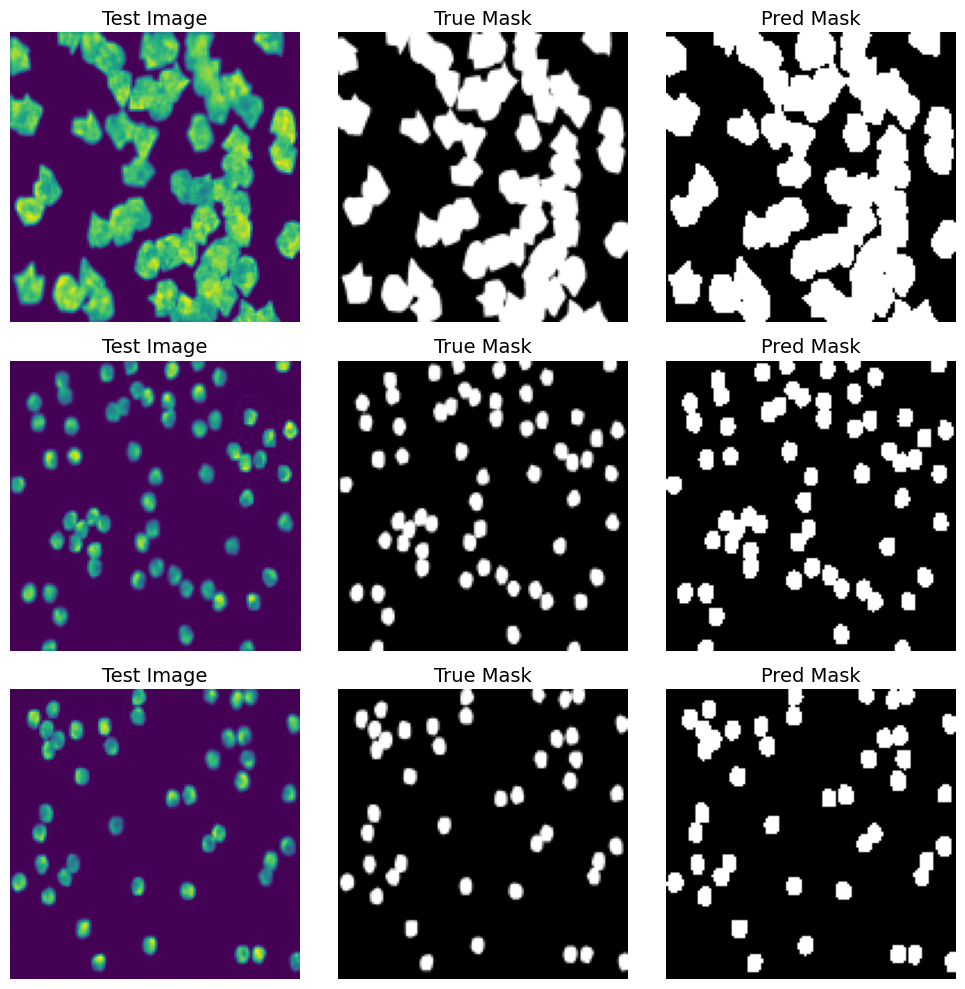

In [29]:
# canvas for subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# ==ROW 1==

# original image
plt.subplot(3,3,1)
test_image = X_test[1, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')

# true mask
plt.subplot(3,3,2)
mask_id = df_test.loc[1,'mask_id']
path_mask = os.path.join('/Users/diyatalwar/Desktop/cells/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth', mask_id)
mask = cv.imread(path_mask)
mask = cv.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# prediction
plt.subplot(3,3,3)
test_mask = preds_test_thresh[1, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# ==ROW 2==

# original image
plt.subplot(3,3,4)
test_image = X_test[2, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')

# true mask
plt.subplot(3,3,5)
mask_id = df_test.loc[2,'mask_id']
path_mask = os.path.join('/Users/diyatalwar/Desktop/cells/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth', mask_id)
mask = cv.imread(path_mask)
mask = cv.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# prediction
plt.subplot(3,3,6)
test_mask = preds_test_thresh[2, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# ==ROW 3==

# original image
plt.subplot(3,3,7)
test_image = X_test[3, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')

# true mask
plt.subplot(3,3,8)
mask_id = df_test.loc[3,'mask_id']
path_mask = os.path.join('/Users/diyatalwar/Desktop/cells/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth', mask_id)
mask = cv.imread(path_mask)
mask = cv.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# prediction
plt.subplot(3,3,9)
test_mask = preds_test_thresh[3, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()